In [ ]:
# run the script initnotebook.py in the cuurent folder
# Error when run multiple times becasue the directory changed
%run initnotebook.py

In [ ]:
import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from config_cityscapes import *
import os
from dataloader.cityscapes_dataloader import CityscapesDataset
from val_segformer_rgbonly import val_cityscape

import torch.nn.functional as F
from utils.visualize import unnormalize_img_numpy
import matplotlib.pyplot as plt

In [ ]:
from visualizer.visualizer import *

In [ ]:
output_dir = '/home/abjawad/Documents/GitHub/local-attention-model/visualizer/images'
if os.path.exists(output_dir):
    print('Output directory exists')

In [ ]:
# # # create a random image tensor of torch.Size([1, 64, 256, 256]) and save it
# img = torch.rand(1, 64, 256, 256)

# save_after_block(img, 'average', output_dir)

In [ ]:
config_path = 'dataloader/cityscapes_rgbd_config.yaml'
config_path = os.path.join(projectFolder, config_path)

cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [ ]:
cityscapes_test = CityscapesDataset(cfg, split='val')
test_loader = DataLoader(cityscapes_test, batch_size=1, shuffle=False, num_workers=4) # batchsize?
print(f'total test sample: {len(cityscapes_test)} v_iteration:{len(test_loader)}')


In [ ]:
pretrained_model_path = './pretrained/model_400.pth'
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)

model = segmodel(cfg=config, criterion=criterion, norm_layer=nn.BatchNorm2d, test=True)
model = nn.DataParallel(model, device_ids = config.device_ids)
# model.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

In [ ]:
saved_model_path = os.path.join(projectFolder, pretrained_model_path)
print(saved_model_path)
# exit()
state_dict = torch.load(saved_model_path)
model.load_state_dict(state_dict['model'], strict=False)
print(f'model loaded')
epoch = state_dict['epoch']


In [ ]:
# val_loss, val_mean_iou = val_cityscape(epoch, test_loader, model)

In [ ]:
def plot_output(img, gt, out):
    # Plot the input image (RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Input Image')
    plt.show()

    # Plot the ground truth (GT)
    plt.figure(figsize=(5, 5))
    plt.imshow(gt[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.show()

    # Convert the output tensor to NumPy and plot the available output channels separately
    out = out[1].cpu().numpy()
    _, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Loop through the 19 channels and plot them
    for i in range(19):
        row, col = divmod(i, 5)  # Calculate the row and column for each subplot
        ax = axes[row, col]  # Get the corresponding subplot
        channel_data = out[0, i, :, :]
        ax.imshow(channel_data, cmap='viridis')  # You can change the colormap as needed
        ax.set_title(f'Channel {i + 1}')  # Set a title for the subplot
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        imgs = sample['image']      #B, 3, 1024, 2048
        gts = sample['label']       #B, 1024, 2048
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

        img = imgs[:, :, :, :1024]
        gt = gts[:, :, :1024]
        loss, out, atten = model(img, gt, visualize=True, attention=True)
        print('loss = ', loss.shape)
        print('out = ', out.shape)
        print('atten = ', len(atten))
        # plot_output(img, gt, out)

        print(img.shape, gt.shape)
        # print(len(out), out[0].shape, out[1].shape)
        break

# tokenization:  torch.Size([1, 65536, 64])
# tokenization:  torch.Size([1, 16384, 128])
# tokenization:  torch.Size([1, 4096, 320])
# tokenization:  torch.Size([1, 1024, 512])

In [ ]:
print(img.shape)
print(len(atten))

In [ ]:
import matplotlib.pyplot as plt


def get_attention_matrix(attention, layer, head):
    # sanity check
    layer = layer - 1
    head = head - 1
    if layer > len(attention):
        print('layer index out of range')
        return None
    if head > len(attention[layer]):
        print('head index out of range')
        return None
    atten = attention[layer][head]
    atten = atten.cpu().numpy()
    return atten

def plot_attention(img, pixel, attention, layer, head, target_size, alpha):
    factor = 4
    layer_factor = 2 ** (layer - 1)
    downsample_factor = factor * layer_factor

    attention = get_attention_matrix(attention, layer, head)

    patch_size = int(np.sqrt(attention.shape[1]))
    unnormalized_image = unnormalize_img_numpy(img)
    rescaled_image_layer = cv2.resize(unnormalized_image, target_size)
    attention_map_layer = np.zeros(target_size)

    downsized_pixel = (pixel[0] // downsample_factor, pixel[1] // downsample_factor)
    downsized_image = unnormalized_image[::downsample_factor, ::downsample_factor]

    array_shape = downsized_image.shape
    patch_idx = (pixel[1] // downsample_factor // patch_size) * (array_shape[1] // patch_size) + (pixel[0] // downsample_factor // patch_size)

    pixel_inside_patch = (((pixel[0] // downsample_factor) % patch_size), ((pixel[1] // downsample_factor) % patch_size))
    pixel_idx_inside_patch = pixel_inside_patch[1] * patch_size + pixel_inside_patch[0]
    attention_patch = attention[patch_idx]
    attention_pixel = attention_patch[pixel_idx_inside_patch].reshape(patch_size, patch_size)

    upscaled_attention_pixel = cv2.resize(attention_pixel, (layer_factor * patch_size, layer_factor * patch_size))
    patch_start = (patch_idx // int(np.sqrt(attention.shape[0])) * patch_size * layer_factor, patch_idx % int(np.sqrt(attention.shape[0])) * patch_size * layer_factor)
    attention_map_layer[patch_start[0]:patch_start[0] + upscaled_attention_pixel.shape[0], patch_start[1]:patch_start[1] + upscaled_attention_pixel.shape[1]] = upscaled_attention_pixel

    plt.imshow(rescaled_image_layer)
    plt.imshow(attention_map_layer, alpha=alpha, cmap='viridis')
    plt.show()


for i in range(1, len(atten)+1):
    for j in range(1, len(atten[i-1])+1):
        shape = get_attention_matrix(atten, i, j).shape
        if len(shape) == 4:
            atten[i-1][j-1] = atten[i-1][j-1].reshape(shape[1], shape[2], shape[3])
        print('attention layer', i, 'head ', j, atten[i-1][j-1].shape)


In [30]:
pixel = (840, 430)
layer = 4
head = 8

attention = get_attention_matrix(atten, layer, head)

factor = 4
layer_factor = 2**(layer - 1)
downsample_factor = factor * layer_factor

target_size = (256, 256)
patch_size = np.sqrt(attention.shape[1]).astype(int)

print('patch_size', patch_size)
print('downsample_factor', downsample_factor)
print("attention shape ", attention.shape, " attention arr type ", type(attention))


patch_size 32
downsample_factor 32
attention shape  (1, 1024, 1024)  attention arr type  <class 'numpy.ndarray'>


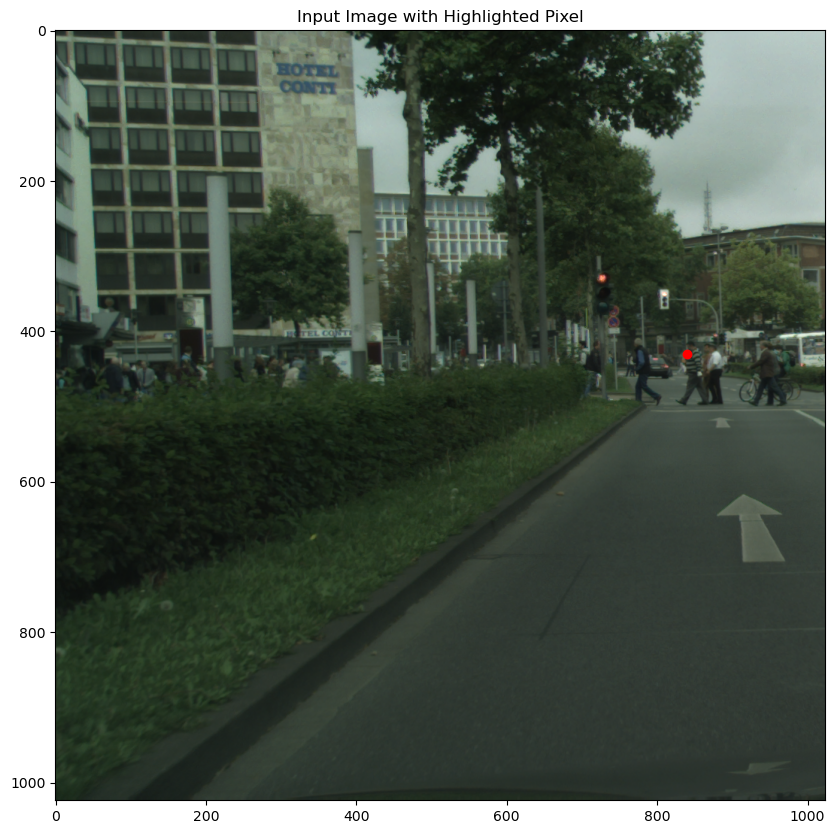

In [33]:
# Convert the tensor to a NumPy array
# image_array = image[0].permute(1, 2, 0).cpu().numpy()
unnormalized_image = unnormalize_img_numpy(img)
image_array = unnormalized_image

plt.figure(figsize=(10, 10))
plt.imshow(image_array)

# Highlight the pixel at (100, 100) in red
plt.scatter(pixel[0], pixel[1], c='red', marker='o')

plt.title('Input Image with Highlighted Pixel')
plt.show()

layer 1 head 1


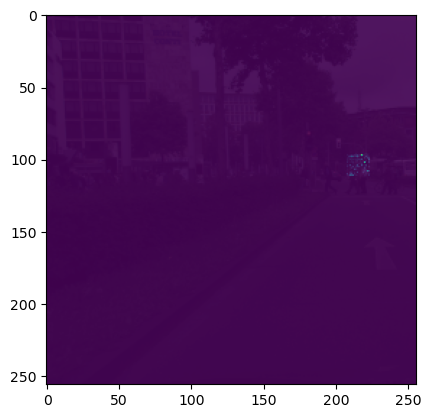

layer 1 head 2


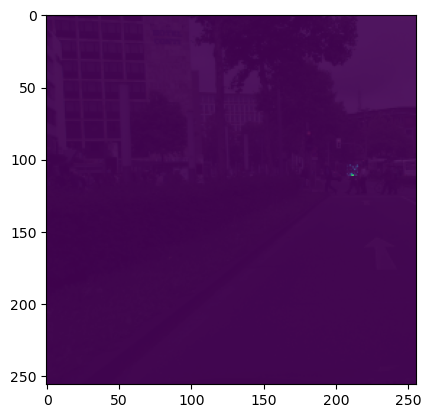

layer 2 head 1


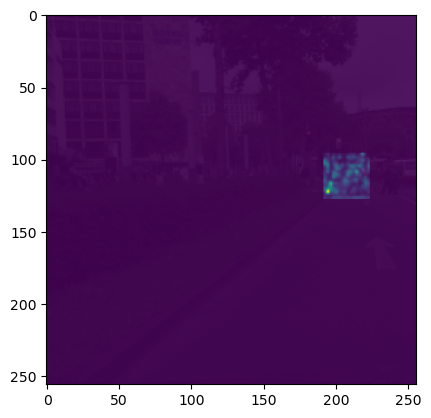

layer 2 head 2


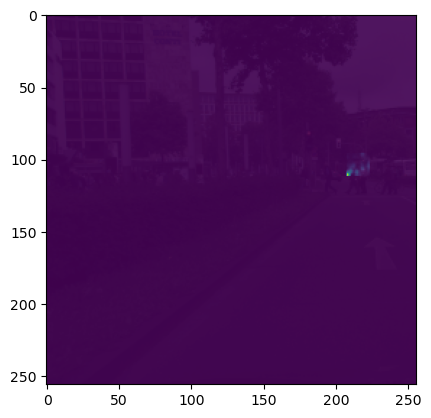

layer 2 head 3


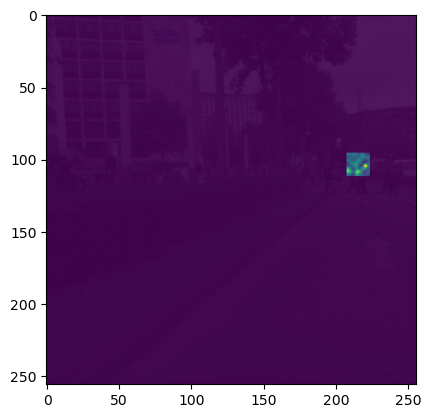

layer 2 head 4


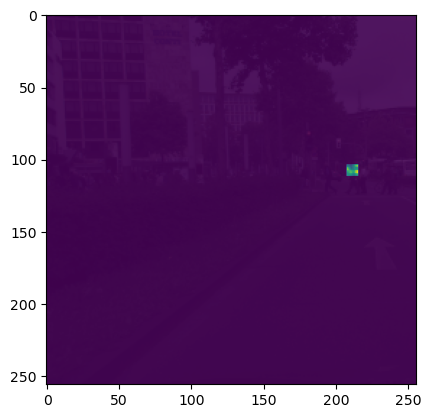

layer 3 head 1


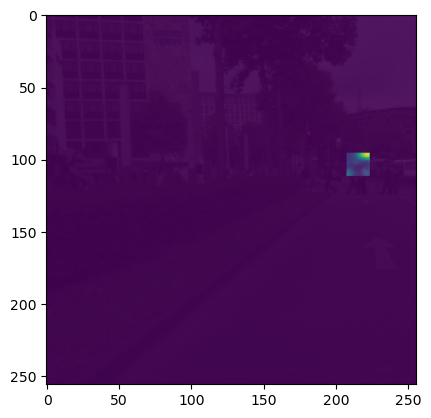

layer 3 head 2


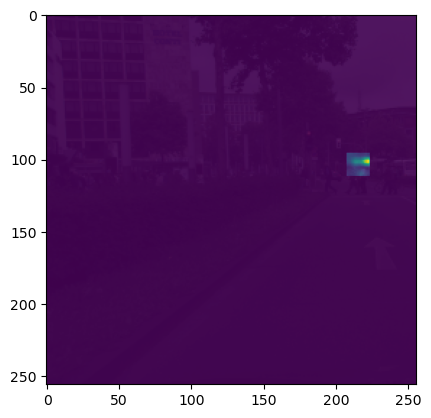

layer 3 head 3


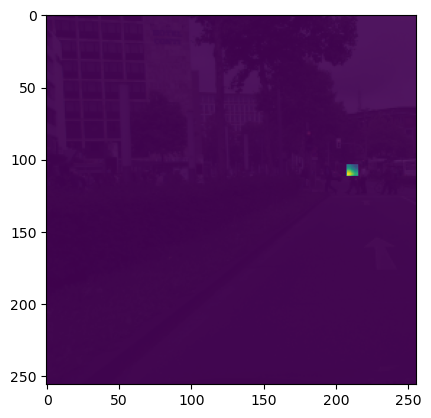

layer 3 head 4


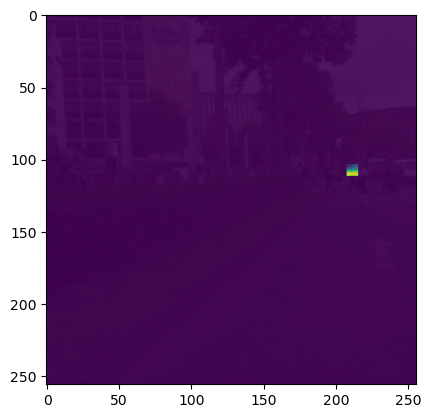

layer 3 head 5


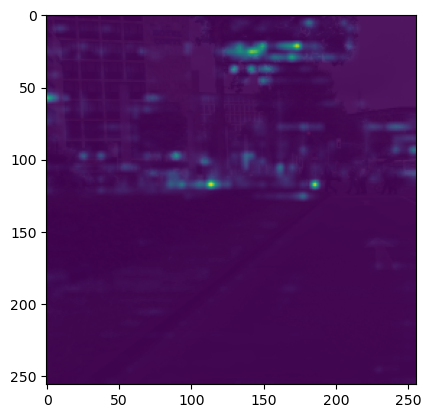

layer 4 head 1


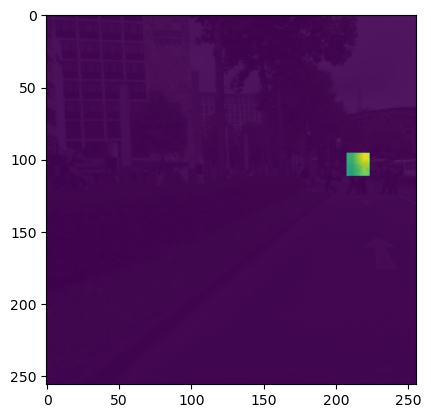

layer 4 head 2


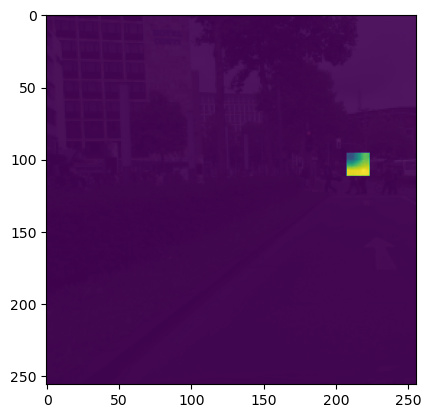

layer 4 head 3


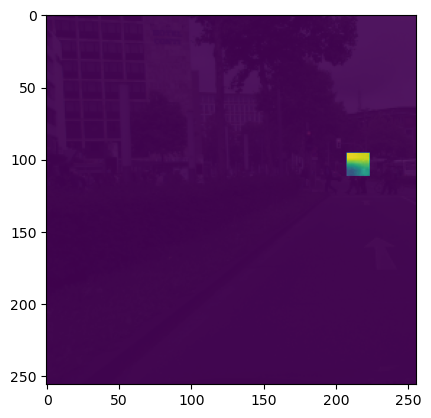

layer 4 head 4


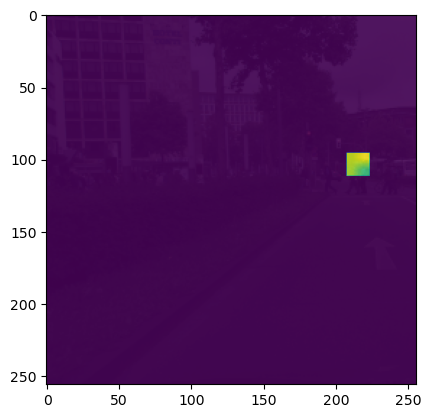

layer 4 head 5


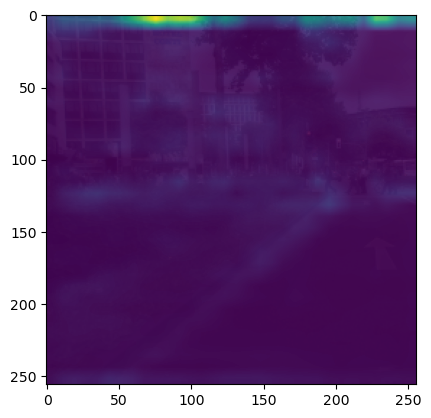

layer 4 head 6


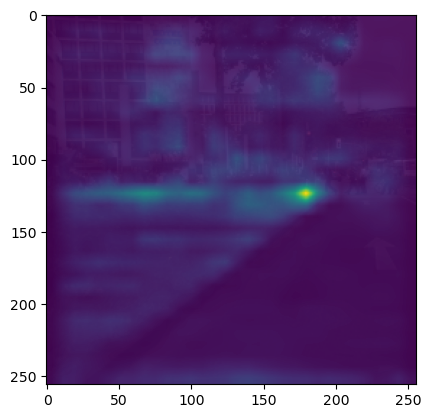

layer 4 head 7


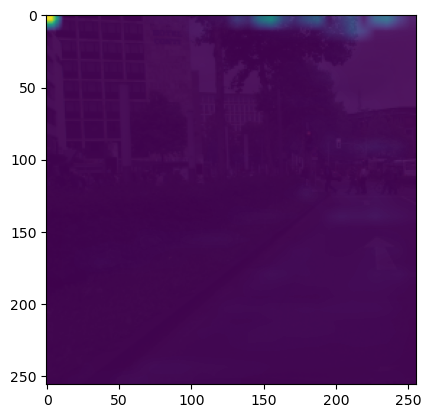

layer 4 head 8


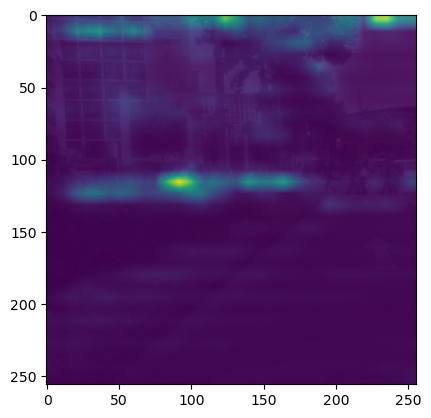

In [34]:
# pixel = (500, 500)
for l in range(1, len(atten)+1):
    for h in range(1, len(atten[l-1])+1):
        print('layer', l, 'head', h)
        plot_attention(img, pixel, atten, l, h, target_size, 0.9)